#### Daniella Raz

# About

This project was done 

# Contents

1. [Imports and Loading Data](#Imports)
2. [Finding Adopted Users](#Finding)
3. [Feature Selection and Exploratory Analysis](#Feature)
    1. [Amending org_id](#Org)
    2. [Amending email_domain](#Email)
    3. [Amending creation_time](#Creation)
    4. [Amending invited_by_user_id](#User)
    5. [Dropping features](#Dropping)
    6. [Plots](#Plots)
    7. [Dummy variables](#Dummy)
    8. [Correlation](#Correlation)
    9. [Cross tab of correlated features](#Cross)
    10. [Data imbalance](#Imbalance)
4. [Modeling](#Modeling)
    1. [Logistic Regression - Undersampled Data](#Logistic)
    2. [Logistic Regression - Full Data](#Full)
5. [Limitations and Suggestions](#Limitations)

# I. Imports and loading data <a name="Imports"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pylab as pl
import warnings
warnings.filterwarnings('ignore')

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls
import plotly.graph_objs as go

import statsmodels.api as sm

%matplotlib inline

In [1]:
import plotly 

In [3]:
user_engagement_df = pd.read_csv("user_engagement.csv")
user_engagement_df.head(5)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
users_df = pd.read_csv("users.csv", encoding = "ISO-8859-1")
users_df.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,yahoo.com
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,gustr.com
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,gustr.com
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,yahoo.com
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,yahoo.com


# II. Finding Adopted Users <a name="Finding"></a>

> Finding adopted users where adopted users defined as: users who visited >= 3 times in 7 day period

In [5]:
# only value for 'visited' is 1, so dropping this column.
user_engagement_df.visited.unique()

array([1])

In [6]:
user_engagement_df = user_engagement_df.drop("visited", 1)

In [7]:
# selecting only those who logged in at least 3 times, meaning appearance of at least...
# ...3 time stamps in the dataframe per user_id

count_df = user_engagement_df.groupby(["user_id"]).count()
min_three = user_engagement_df.loc[user_engagement_df["user_id"].isin(count_df[count_df["time_stamp"] >= 3].index)]

In [8]:
min_three.head(5)

,time_stamp,user_id
1,2013-11-15 03:45:04,2
2,2013-11-29 03:45:04,2
3,2013-12-09 03:45:04,2
4,2013-12-25 03:45:04,2
5,2013-12-31 03:45:04,2


In [9]:
min_three["time_stamp"] =  pd.to_datetime(min_three["time_stamp"], format='%Y-%m-%d %H:%M:%S')

In [10]:
min_three.head(5)

,time_stamp,user_id
1,2013-11-15 03:45:04,2
2,2013-11-29 03:45:04,2
3,2013-12-09 03:45:04,2
4,2013-12-25 03:45:04,2
5,2013-12-31 03:45:04,2


In [11]:
# finding earliest date, and latest date, aka the date range

earliest_date = min_three.time_stamp.min()
latest_date = min_three.time_stamp.max()

In [12]:
# function source: Thibault Keterer at https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [13]:
# create a set to have non-repeating user_ids that are adopted users
full_adopted_list = list()

# establish an earliest date and latest date through which to iterate
for i in daterange(earliest_date, latest_date):
    # the current end of 7 day date range to be checked for id's that show up at least 3 time
    new_end_date = i + timedelta(days=6)

    # date at which loop should stop, because there aren't 7 days left
    upper_limit = latest_date - timedelta(days=7)

    # break when towards end of date range and fewer than 7 days left
    if (new_end_date > upper_limit):
        break
    # else, filter dataframe for the dates within that seven day range
    else:
        date_df = min_three[(min_three["time_stamp"] > i) & (min_three["time_stamp"] < new_end_date)]  
        
        # count/groupby how many of each user_id shows up, if count >= 3 then add to set
        adopted_users_list = date_df.user_id.value_counts()[date_df.user_id.value_counts()>=3].index.tolist()
        
        full_adopted_list.extend(adopted_users_list)
            
    # iterate through the complete date range at 1-day increments
    i = i + timedelta(days=1)

In [14]:
adopted_users = set(full_adopted_list)

In [15]:
# sanity check:
# comparing number of unique adopted users with full length of adopted users, w/ repeat IDs
print(len(adopted_users))
print(len(full_adopted_list))

1520
204087


In [16]:
# adding column for adopted users, if adopted then value = 1, else = 0
users_df["adopted"] = np.where(users_df["object_id"].isin(adopted_users), 1, 0)

In [17]:
# sanity check
users_df.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,yahoo.com,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,gustr.com,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,gustr.com,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,yahoo.com,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,yahoo.com,0


# III. Feature Selection <a name="Feature"></a>

> Before jumping into models, I want to explore some basic, but informative, characteristics of the data and better understand the features themselves (distributions, noise, correlations and interactions, etc).

## A. Amending org_id <a name="Org"></a>

> Changing org_id metric to reflect the size of the organization as opposed to the arbitrary org_id value. Without additional attributes describing the organization (its characteristics, type of company etc) the org_id is not a useful metric. However, it is possible to use org_id to calculate the size of the organization based on the frequency of the org_id in the dataframe.

In [18]:
# how many users are not members of an org
len(users_df[users_df['org_id'] == 0])

319

In [19]:
# what are the largest organizations in terms of membership numbers in this dataset
orgs_member_count = users_df['org_id'].value_counts()
print("Number of unique orgs: ", len(orgs_member_count))
print("OrgID  NumMembers")
print(orgs_member_count.head(10))

Number of unique orgs:  417
OrgID  NumMembers
0     319
1     233
2     201
3     168
4     159
6     138
5     128
9     124
7     119
10    104
Name: org_id, dtype: int64


In [20]:
# what is the distribution of sizes of organizations?
# checking distribution of organization size... 
# ...to get a feeling for what constitutes a large org, medium org, small org
orgs_member_count.describe()

count    417.000000
mean      28.776978
std       27.560173
min        2.000000
25%       17.000000
50%       22.000000
75%       29.000000
max      319.000000
Name: org_id, dtype: float64

In [21]:
# creating a column for org_size
users_df['org_num_members'] = users_df.groupby(['org_id'])['object_id'].transform('count')
users_df.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain,adopted,org_num_members
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,yahoo.com,0,75
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,gustr.com,1,233
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,gustr.com,0,32
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,yahoo.com,0,233
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,yahoo.com,0,16


In [22]:
# sanity check, should be the same output
print(len(users_df['org_num_members'].value_counts()))
print(len(orgs_member_count.unique()))

75
75


In [23]:
len(users_df)

12000

In [24]:
# dropping org_id
users_df = users_df.drop(columns=["org_id"])

In [25]:
users_df.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,email_domain,adopted,org_num_members
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,10803.0,yahoo.com,0,75
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,316.0,gustr.com,1,233


## B. Amending email_domain <a name="Email"></a>

> The vast majority (90%) of email_domains are one of six email domains ("gmail.com", "yahoo.com", "jourrapide.com", "cuvox.de", "gustr.com", "hotmail.com"). Thus, I am retaining the email_domain value for users who sign up with one of those most common email domains, and changing the value of email_domain to "other" for users who did not sign up with one of those 6 domains.

In [26]:
email_domains = users_df['email_domain'].value_counts()
email_domains.head(10)

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
rerwl.com            2
qgjbc.com            2
xvnbr.com            2
xybhi.com            2
Name: email_domain, dtype: int64

In [27]:
top_domains = ["gmail.com", "yahoo.com", "jourrapide.com", "cuvox.de", "gustr.com", "hotmail.com"]
email_domains = email_domains.drop(labels=top_domains)
# sanity check
email_domains.head(3)

rerwl.com    2
qgjbc.com    2
xvnbr.com    2
Name: email_domain, dtype: int64

In [28]:
lower_domains = email_domains.index.tolist()

In [29]:
# renaming the values in email_domain to "other" if the value is not in list of top 6 email_domains
# otherwise retaining the email_domain value as is
users_df["email"] = users_df["email_domain"]
users_df.loc[users_df["email_domain"].isin(lower_domains), "email"] = "other"

In [30]:
# sanity check, should be same value
print(len(users_df))
print(len(users_df.email.unique()))

12000
7


In [31]:
# dropping email_domain
users_df = users_df.drop(columns=["email_domain"])

In [32]:
# sanity check
users_df.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,adopted,org_num_members
0,1,2014-04-22 03:53:30,Clausen August,yahoo.com,GUEST_INVITE,1.398139e+09,1,0,10803.0,0,75
1,2,2013-11-15 03:45:04,Poole Matthew,gustr.com,ORG_INVITE,1.396238e+09,0,0,316.0,1,233


## C. Amending creation_time <a name="Creation"></a>

> Changing creation_time metric to reflect the weekday on which the account was created as opposed to the entire date with minutes and seconds. Then ammending to weekend or weekday. Weekday creation of the account would suggest perhaps that usage is work-related, whereas on the weekend might suggest personal usage outside of work.

In [33]:
# checking data type of creation_time 
x = users_df.iloc[0]["creation_time"]
print(type(x))
print(x)

<class 'str'>
2014-04-22 03:53:30


In [34]:
# transform from string to datetime object
users_df["creation_time"] = pd.to_datetime(users_df["creation_time"])

In [35]:
# create column with day of week based off of datetime creation_time column
users_df["day_of_week"] = users_df["creation_time"].dt.weekday_name

In [36]:
# sanity check 
users_df.head(1)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,adopted,org_num_members,day_of_week
0,1,2014-04-22 03:53:30,Clausen August,yahoo.com,GUEST_INVITE,1.398139e+09,1,0,10803.0,0,75,Tuesday


In [37]:
# drop creation_time
users_df = users_df.drop(columns = ["creation_time"])

In [38]:
# weekend = 0, weekday = 1
users_df["day_of_week"].loc[users_df["day_of_week"] == "Friday"] = 0
users_df["day_of_week"].loc[users_df["day_of_week"] == "Saturday"] = 0
users_df["day_of_week"].loc[users_df["day_of_week"] == "Sunday"] = 0
users_df["day_of_week"].loc[users_df["day_of_week"] != 0] = 1
users_df.head(5)

,object_id,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,adopted,org_num_members,day_of_week
0,1,Clausen August,yahoo.com,GUEST_INVITE,1.398139e+09,1,0,10803.0,0,75,1
1,2,Poole Matthew,gustr.com,ORG_INVITE,1.396238e+09,0,0,316.0,1,233,0
2,3,Bottrill Mitchell,gustr.com,ORG_INVITE,1.363735e+09,0,0,1525.0,0,32,1
3,4,Clausen Nicklas,yahoo.com,GUEST_INVITE,1.369210e+09,0,0,5151.0,0,233,1
4,5,Raw Grace,yahoo.com,GUEST_INVITE,1.358850e+09,0,0,5240.0,0,16,1


In [39]:
# checking for nan's in day_of_week as sanity check
users_df.isna().sum()

object_id                        0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
invited_by_user_id            5583
adopted                          0
org_num_members                  0
day_of_week                      0
dtype: int64

## D. Amending invited_by_user_id <a name="User"></a>

> Changing invited_by_user_id to binary --> was the user invited/referred by another user or not. Given time constraints, the specific user who referred them is not relevant at this stage. However, with more time an avenue to potentially explore further would be some sort of network analysis to determine if certain users/companies are 'hotspots' for adopted users.

In [40]:
# out of 12000 users, 5583 were NOT invited by another user
users_df.isna().sum()

object_id                        0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
invited_by_user_id            5583
adopted                          0
org_num_members                  0
day_of_week                      0
dtype: int64

In [41]:
# of the 6,417 users who were invited by another user, there are 2565 unique users who did so
# meaning lots of users who invite multiple people
# does the amount of users you have invited somehow help identify whether you are an adopted user or not?
len(users_df.invited_by_user_id.unique())

2565

In [42]:
test = users_df['invited_by_user_id'].value_counts()
test.head(10)

10741.0    13
2527.0     12
2308.0     11
1525.0     11
11770.0    11
10628.0    10
7012.0     10
4612.0     10
4803.0     10
1175.0     10
Name: invited_by_user_id, dtype: int64

In [43]:
test.describe()

count    2564.000000
mean        2.502730
std         1.900262
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        13.000000
Name: invited_by_user_id, dtype: float64

In [44]:
len(test)

2564

In [45]:
# constraints due to time but would be interesting to look at the ogranizations that..
# ...the users who invite a lot of people are from 
users_df["invited_by_user"] = np.where(users_df["invited_by_user_id"] >= 0, 1, 0)

In [46]:
# sanity check = are there 5583 users not invited by another user
len(users_df.loc[users_df["invited_by_user"] == 0])

5583

In [47]:
# dropping invited_by_user_id column
users_df = users_df.drop(columns=["invited_by_user_id"])

In [48]:
users_df.head(5)

,object_id,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,org_num_members,day_of_week,invited_by_user
0,1,Clausen August,yahoo.com,GUEST_INVITE,1.398139e+09,1,0,0,75,1,1
1,2,Poole Matthew,gustr.com,ORG_INVITE,1.396238e+09,0,0,1,233,0,1
2,3,Bottrill Mitchell,gustr.com,ORG_INVITE,1.363735e+09,0,0,0,32,1,1
3,4,Clausen Nicklas,yahoo.com,GUEST_INVITE,1.369210e+09,0,0,0,233,1,1
4,5,Raw Grace,yahoo.com,GUEST_INVITE,1.358850e+09,0,0,0,16,1,1


## E. Dropping Features <a name="Dropping"></a>

> Dropping features that are not meaningful: object_id, name, and last_session_creation_time

In [49]:
users_df_final = users_df.drop(["object_id", "name", "last_session_creation_time"], axis=1)

In [50]:
# sanity check
users_df_final.head(2)

,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,org_num_members,day_of_week,invited_by_user
0,yahoo.com,GUEST_INVITE,1,0,0,75,1,1
1,gustr.com,ORG_INVITE,0,0,1,233,0,1


## F. Plots <a name="Plots"></a>

> I think the most useful plots for getting a feel for which features are associated with higher rates of user adoptions would be those that show total users in each category, and what percent of those total users are adopted. My strategy here is to make some stacked bar charts, with total user count, adopted user count, and then annotations of the percent of total users which adopted users account for. 

> Looking at the plots, creation_source, email domain, and invited by user show different rates of adoption based on the users onboarding source, email domain, and whether or not they were invited by another user, respectively. This suggests these features have potential to be good predictors of user adoption. In contrast, whether a user opted in to mailing list, is enabled for the marketing drip, or created their account on a weekend or a weekday shows no association with user adoption. Adoption rates are equal within those plots.

### Dataframe for plotting

In [51]:
# easier to plot in plotly histogram when categorical variable names have numeric values, 
# so adjusting this

# converting creation_source and email to categorical type in order to use cat.codes
plotting_df = users_df_final.copy()
plotting_df["creation_source"] = plotting_df["creation_source"].astype('category')
plotting_df["email"] = plotting_df["email"].astype('category')

# mapping codes and categories to reference later
creation_dict = dict(enumerate(plotting_df["creation_source"].cat.categories))
print("Creation Source Mappings: \n", creation_dict)

# mapping codes and categories to reference later
domain_dict = dict(enumerate(plotting_df["email"].cat.categories))
print("Email Domain Mappings: \n", domain_dict)

# numeric encoding of categorical variables
plotting_df["creation_source"] = plotting_df["creation_source"].cat.codes
plotting_df["email"] = plotting_df["email"].cat.codes
plotting_df.head(2)

Creation Source Mappings: 
 {0: 'GUEST_INVITE', 1: 'ORG_INVITE', 2: 'PERSONAL_PROJECTS', 3: 'SIGNUP', 4: 'SIGNUP_GOOGLE_AUTH'}
Email Domain Mappings: 
 {0: 'cuvox.de', 1: 'gmail.com', 2: 'gustr.com', 3: 'hotmail.com', 4: 'jourrapide.com', 5: 'other', 6: 'yahoo.com'}


,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,org_num_members,day_of_week,invited_by_user
0,6,0,1,0,0,75,1,1
1,2,1,0,0,1,233,0,1


In [52]:
# metrics to be graphed and for which to calculate percent adopted
metrics = ["creation_source", 
           "opted_in_to_mailing_list", 
           "enabled_for_marketing_drip",
           "email",
           "day_of_week", 
           "invited_by_user"]

# created dataframe of only adopted users
adopted_data = plotting_df.loc[plotting_df["adopted"] == 1]

In [53]:
total_adopted_list = []
total_counts_list = []

for metric in metrics:
    # finding counts of all adopted per category of each metric
    a_total = plotting_df.groupby([metric, 'adopted']).agg({'opted_in_to_mailing_list': 'count'})
    adopted_count_df = a_total.reset_index('adopted')
    adopted_count_df = adopted_count_df[adopted_count_df.adopted != 0]
    adopted_counts_list = adopted_count_df['opted_in_to_mailing_list'].tolist()
    total_adopted_list.extend(adopted_counts_list)
    
    # finding counts of total users per category of each metric 
    total_counts = plotting_df[metric].value_counts().sort_index()
    counts_list = total_counts.tolist()
    total_counts_list.extend(counts_list)

In [54]:
# calculating percent of adopted users for each category within each metric
percent_labels = [x / y * 100 for x, y in zip(total_adopted_list, total_counts_list)]
percent_labels = ['%.0f' % x for x in percent_labels]
percent_labels = [x + '%' for x in percent_labels]

In [55]:
# sanity checks
print(total_adopted_list)
print(total_counts_list)
print(percent_labels)

[339, 524, 154, 285, 218, 1128, 392, 1283, 237, 129, 506, 137, 190, 157, 152, 249, 651, 869, 657, 863]
[2163, 4254, 2111, 2087, 1385, 9006, 2994, 10208, 1792, 1202, 3562, 1179, 1165, 1259, 1186, 2447, 5140, 6860, 5583, 6417]
['16%', '12%', '7%', '14%', '16%', '13%', '13%', '13%', '13%', '11%', '14%', '12%', '16%', '12%', '13%', '10%', '13%', '13%', '12%', '13%']


### Creation_Source Plot

In [56]:
# colors dictionary, adopted = blue, total user count = orange
colors = {'A': 'rgb(31, 119, 180)', 
          'T': 'rgb(255, 127, 14)',}  

# labels and tick vals
creation_labels = ["Guest Invite", 
                   "Organization Invite", 
                   "Personal Projects", 
                   "Signup", 
                   "Signup Google Auth"]
creation_tickvals = [0, 1, 2, 3, 4]

# creating trace of stats for adopted users only
adopted_users = Histogram(
    x = adopted_data["creation_source"].values,
    opacity = 0.75,
    marker = Marker(color = colors['A']),
    name = "Adopted Users",
    showlegend = True, 
)

# creating trace of stats for total users
total_users = Histogram(
    x = plotting_df["creation_source"].values,
    opacity = 0.75,
    marker = Marker(color = colors['T']),
    name = "Total Users",
    showlegend = True,
)

# creation_source annotations of percent adopted
annotation_arr = []
metric_count = 0
for percent, count in zip(percent_labels[0:5], total_adopted_list[0:5]):
    annotation_arr.append(dict(x=metric_count, 
                               y=count,
                               text=percent,
                               showarrow=True,
                               arrowhead=7,
                               ax=0,
                               ay=-30))
    metric_count = metric_count + 1

data = [adopted_users, total_users]
layout = go.Layout(barmode='stack', 
                   height = 550, 
                   width = 650, 
                   title = "Percent Adopted Users per Creation Source",
                   bargap = 0.2, 
                    xaxis=go.layout.XAxis(
                        ticktext=creation_labels,
                        tickvals=creation_tickvals),
                  annotations = annotation_arr)
    
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Creation Source Histogram')

/Users/daniellaraz/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:426: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




### Opted into Mailing List Plot

In [57]:
# labels and tick vals
yes_no_labels = ["No", "Yes"]
yes_no_vals = [0, 1]

# creating trace of stats for adopted users only
adopted_users = Histogram(
    x = adopted_data["opted_in_to_mailing_list"].values,
    opacity = 0.75,
    marker = Marker(color = colors['A']),
    name = "Adopted Users",
    showlegend = True, 
)

# creating trace of stats for total users
total_users = Histogram(
    x = plotting_df["opted_in_to_mailing_list"].values,
    opacity = 0.75,
    marker = Marker(color = colors['T']),
    name = "Total Users",
    showlegend = True,
)

# creation_source annotations of percent adopted
annotation_arr = []
metric_count = 0
for percent, count in zip(percent_labels[5:7], total_adopted_list[5:7]):
    annotation_arr.append(dict(x=metric_count, 
                               y=count,
                               text=percent,
                               showarrow=True,
                               arrowhead=7,
                               ax=0,
                               ay=-30))
    metric_count = metric_count + 1

data = [adopted_users, total_users]
layout = go.Layout(barmode='stack', 
                   height = 400, 
                   width = 500, 
                   title = "Percent Adopted Users Opting in or out of Mailing List",
                   bargap = 0.2, 
                   xaxis=go.layout.XAxis(
                       ticktext=yes_no_labels,
                       tickvals=yes_no_vals),
                  annotations = annotation_arr)
    
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Mailing List Histogram')

/Users/daniellaraz/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:426: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




### Enabled for Marketing Drip Plot

In [58]:
# creating trace of stats for adopted users only
adopted_users = Histogram(
    x = adopted_data["enabled_for_marketing_drip"].values,
    opacity = 0.75,
    marker = Marker(color = colors['A']),
    name = "Adopted Users",
    showlegend = True, 
)

# creating trace of stats for total users
total_users = Histogram(
    x = plotting_df["enabled_for_marketing_drip"].values,
    opacity = 0.75,
    marker = Marker(color = colors['T']),
    name = "Total Users",
    showlegend = True,
)

# enabled for marketing drip annotations of percent adopted
annotation_arr = []
metric_count = 0
for percent, count in zip(percent_labels[7:9], total_adopted_list[7:9]):
    annotation_arr.append(dict(x=metric_count, 
                               y=count,
                               text=percent,
                               showarrow=True,
                               arrowhead=7,
                               ax=0,
                               ay=-25))
    metric_count = metric_count + 1

data = [adopted_users, total_users]
layout = go.Layout(barmode='stack', 
                   height = 400, 
                   width = 550, 
                   title = "Percent Adopted Users: Enabled or Disabled Marketing Drip",
                   bargap = 0.2, 
                   xaxis=go.layout.XAxis(
                       ticktext=yes_no_labels,
                       tickvals=yes_no_vals),
                  annotations = annotation_arr)
    
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Marketing Drip Histogram')

/Users/daniellaraz/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:426: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




### Email Domain Plot

In [59]:
# colors dictionary, adopted = blue, total user count = orange
colors = {'A': 'rgb(31, 119, 180)', 
          'T': 'rgb(255, 127, 14)',}  

# labels and tick vals
creation_labels = ["cuvox.de", "gmail.com", "gustr.com", "hotmail.com", "jourrapide.com", "yahoo.com", "other"]
creation_tickvals = [0, 1, 2, 3, 4, 5, 6]

# creating trace of stats for adopted users only
adopted_users = Histogram(
    x = adopted_data["email"].values,
    opacity = 0.75,
    marker = Marker(color = colors['A']),
    name = "Adopted Users",
    showlegend = True, 
)

# creating trace of stats for total users
total_users = Histogram(
    x = plotting_df["email"].values,
    opacity = 0.75,
    marker = Marker(color = colors['T']),
    name = "Total Users",
    showlegend = True,
)

# creation_source annotations of percent adopted
annotation_arr = []
metric_count = 0
for percent, count in zip(percent_labels[9:16], total_adopted_list[9:16]):
    annotation_arr.append(dict(x=metric_count, 
                               y=count,
                               text=percent,
                               showarrow=True,
                               arrowhead=7,
                               ax=0,
                               ay=-30))
    metric_count = metric_count + 1

data = [adopted_users, total_users]
layout = go.Layout(barmode='stack', 
                   height = 500, 
                   width = 600, 
                   title = "Percent Adopted Users per Email Domain",
                   bargap = 0.2, 
                   xaxis=go.layout.XAxis(
                       ticktext=creation_labels,
                       tickvals=creation_tickvals),
                  annotations = annotation_arr)
    
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Email Domain Histogram')

/Users/daniellaraz/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:426: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




### Weekend vs. Weekday Plot

In [60]:
# labels and tick vals
day_labels = ["Weekend", "Weekday"]
day_vals = [0, 1]

# creating trace of stats for adopted users only
adopted_users = Histogram(
    x = adopted_data["day_of_week"].values,
    opacity = 0.75,
    marker = Marker(color = colors['A']),
    name = "Adopted Users",
    showlegend = True, 
)

# creating trace of stats for total users
total_users = Histogram(
    x = plotting_df["day_of_week"].values,
    opacity = 0.75,
    marker = Marker(color = colors['T']),
    name = "Total Users",
    showlegend = True,
)

# day of week annotations of percent adopted
annotation_arr = []
metric_count = 0
for percent, count in zip(percent_labels[16:18], total_adopted_list[16:18]):
    annotation_arr.append(dict(x=metric_count, 
                               y=count,
                               text=percent,
                               showarrow=True,
                               arrowhead=7,
                               ax=0,
                               ay=-25))
    metric_count = metric_count + 1

data = [adopted_users, total_users]
layout = go.Layout(barmode='stack', 
                   height = 400, 
                   width = 500, 
                   title = "Percent Adopted Users: Weekend vs. Weekday",
                   bargap = 0.2, 
                   xaxis=go.layout.XAxis(
                       ticktext=day_labels,
                       tickvals=day_vals),
                  annotations = annotation_arr)
    
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Day of Week Histogram')

/Users/daniellaraz/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:426: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




### Invited by User Plot

In [61]:
# creating trace of stats for adopted users only
adopted_users = Histogram(
    x = adopted_data["invited_by_user"].values,
    opacity = 0.75,
    marker = Marker(color = colors['A']),
    name = "Adopted Users",
    showlegend = True, 
)

# creating trace of stats for total users
total_users = Histogram(
    x = plotting_df["invited_by_user"].values,
    opacity = 0.75,
    marker = Marker(color = colors['T']),
    name = "Total Users",
    showlegend = True,
)

# enabled for marketing drip annotations of percent adopted
annotation_arr = []
metric_count = 0
for percent, count in zip(percent_labels[18:20], total_adopted_list[18:20]):
    annotation_arr.append(dict(x=metric_count, 
                               y=count,
                               text=percent,
                               showarrow=True,
                               arrowhead=7,
                               ax=0,
                               ay=-25))
    metric_count = metric_count + 1

data = [adopted_users, total_users]
layout = go.Layout(barmode='stack', 
                   height = 400, 
                   width = 500, 
                   title = "Percent Adopted Users: Invited by User",
                   bargap = 0.2, 
                   xaxis=go.layout.XAxis(
                       ticktext=yes_no_labels,
                       tickvals=yes_no_vals),
                  annotations = annotation_arr)
    
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Invited by User Histogram')

/Users/daniellaraz/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:426: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




### Organization Size Plots

In [62]:
 adopted_users = Histogram(
     x = adopted_data["org_num_members"].values,
     opacity = 0.75,
     marker = Marker(color = colors['A']),
     name = "Adopted Users",
     showlegend = True, 
 )
total_users = Histogram(
     x = plotting_df["org_num_members"].values,
     opacity = 0.75,
     marker = Marker(color = colors['T']),
     name = "Total Users",
     showlegend = True,
 )

data = [adopted_users, total_users]



layout = go.Layout(barmode='stack', 
                   height = 500, 
                   width = 800, 
                   title = "Total Users vs. Adopted Users by Organization Size")

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Organization Size Histogram')

/Users/daniellaraz/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:426: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




## G. Dummy Variables <a name="Dummy"></a>

In [63]:
# creating dummy variables for creation_source and emails
users_df_dummies = pd.get_dummies(users_df_final, 
                                  columns=["creation_source", "email"], 
                                  drop_first=False, 
                                  prefix = ["creation_", "email_"])
users_df_dummies.head(5)

,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,org_num_members,day_of_week,invited_by_user,creation__GUEST_INVITE,creation__ORG_INVITE,creation__PERSONAL_PROJECTS,creation__SIGNUP,creation__SIGNUP_GOOGLE_AUTH,email__cuvox.de,email__gmail.com,email__gustr.com,email__hotmail.com,email__jourrapide.com,email__other,email__yahoo.com
0,1,0,0,75,1,1,1,0,0,0,0,0,0,0,0,0,0,1
1,0,0,1,233,0,1,0,1,0,0,0,0,0,1,0,0,0,0
2,0,0,0,32,1,1,0,1,0,0,0,0,0,1,0,0,0,0
3,0,0,0,233,1,1,1,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,16,1,1,1,0,0,0,0,0,0,0,0,0,0,1


## H. Correlation Checks <a name="Correlation"></a>

> There are four pairs of features that seem relatively correlated. enabled_for_marketing_drip and opted_in_to_mailing_list, creation_ORG_INVITE and invited_by_user, creation_GUEST_INVITE and invited_by_user, as well as email_gmail.com and and creation_SIGNUP_GOOGLE_AUTH. I'll examine these more closesly in crosstabs.

In [64]:
corr_df = users_df_dummies.corr()

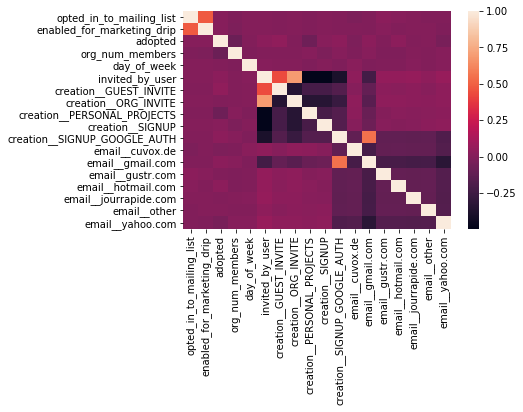

In [65]:
sns.heatmap(corr_df)

## I. Crosstab of Correlated Features<a name="Cross"></a>

> Three important takeaways, that make intuitive sense as well, from the cross tabulation of correlated features:

> All users who signed up for the product using Google authorization have gmail.com as their email domain. There are 0 users who signed up with Google and do not have gmail.com as their email domain. 

> All users whose creation source for the product was an organization invite were invited by a user.  There are 0 users who signed up for the product using an organization invite who were not invited by a user.

> All users whose creation source for the product was a guest invite were invited by a user. There are 0 users who signed up for the product using a guest invite who were not invited by another user.

> To prevent separation in logistic model and issues of multicollinearity I am retaining the following features from each pair: invited_by_user and email_gmail.com. email_gmail.com and invited_by_user are features that reflect larger trends - 1) using Google service (gmail), and 2) being invited to create an account by some "inside" source, either an organization via a user, or a guest invite via a user.

In [66]:
# making list of lists, feature pairs to check crosstab
cross_tab_features = [["creation__SIGNUP_GOOGLE_AUTH", "email__gmail.com"],
                      ["creation__ORG_INVITE", "invited_by_user"], 
                      ["creation__GUEST_INVITE", "invited_by_user"],
                      ["enabled_for_marketing_drip", "opted_in_to_mailing_list"]]

In [67]:
for pairing in cross_tab_features:
    print(pd.crosstab(users_df_dummies[pairing[0]],
                           users_df_dummies[pairing[1]],
                           rownames = [pairing[0]]))
    print("\n")

email__gmail.com                 0     1
creation__SIGNUP_GOOGLE_AUTH            
0                             8438  2177
1                                0  1385


invited_by_user          0     1
creation__ORG_INVITE            
0                     5583  2163
1                        0  4254


invited_by_user            0     1
creation__GUEST_INVITE            
0                       5583  4254
1                          0  2163


opted_in_to_mailing_list       0     1
enabled_for_marketing_drip            
0                           8556  1652
1                            450  1342




In [68]:
users_df_dummies = users_df_dummies.drop(["creation__SIGNUP_GOOGLE_AUTH", 
                                "creation__ORG_INVITE", 
                                "creation__GUEST_INVITE"], axis=1)

In [69]:
users_df_dummies.head(5)

,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,org_num_members,day_of_week,invited_by_user,creation__PERSONAL_PROJECTS,creation__SIGNUP,email__cuvox.de,email__gmail.com,email__gustr.com,email__hotmail.com,email__jourrapide.com,email__other,email__yahoo.com
0,1,0,0,75,1,1,0,0,0,0,0,0,0,0,1
1,0,0,1,233,0,1,0,0,0,0,1,0,0,0,0
2,0,0,0,32,1,1,0,0,0,0,1,0,0,0,0
3,0,0,0,233,1,1,0,0,0,0,0,0,0,0,1
4,0,0,0,16,1,1,0,0,0,0,0,0,0,0,1


In [70]:
# dropping reference category dummy variables
users_df_dummies = users_df_dummies.drop(["creation__PERSONAL_PROJECTS", 
                                "email__cuvox.de"], axis=1)

In [71]:
users_df_dummies.head(5)

,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,org_num_members,day_of_week,invited_by_user,creation__SIGNUP,email__gmail.com,email__gustr.com,email__hotmail.com,email__jourrapide.com,email__other,email__yahoo.com
0,1,0,0,75,1,1,0,0,0,0,0,0,1
1,0,0,1,233,0,1,0,0,1,0,0,0,0
2,0,0,0,32,1,1,0,0,1,0,0,0,0
3,0,0,0,233,1,1,0,0,0,0,0,0,1
4,0,0,0,16,1,1,0,0,0,0,0,0,1


## J. Data Imbalance <a name="Imbalance"></a>

> Data is highly skewed, around 87% are non-adopted users.

> Using undersampling of majority non-adopted to create more balanced dataset.

In [72]:
users_df_dummies['adopted'].value_counts()

0    10480
1     1520
Name: adopted, dtype: int64

In [73]:
# source: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
count_class_0, count_class_1 = users_df_dummies.adopted.value_counts()

df_class_0 = users_df_dummies[users_df_dummies['adopted'] == 0]
df_class_1 = users_df_dummies[users_df_dummies['adopted'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
users_df_balanced = pd.concat([df_class_0_under, df_class_1], axis=0)

print(users_df_balanced.adopted.value_counts())

1    1520
0    1520
Name: adopted, dtype: int64


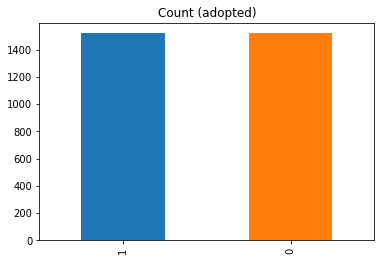

In [74]:
users_df_balanced.adopted.value_counts().plot(kind='bar', title='Count (adopted)')

In [75]:
users_df_balanced.head(5)

,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,org_num_members,day_of_week,invited_by_user,creation__SIGNUP,email__gmail.com,email__gustr.com,email__hotmail.com,email__jourrapide.com,email__other,email__yahoo.com
3656,0,0,0,33,1,1,0,1,0,0,0,0,0
3304,0,0,0,18,0,1,0,1,0,0,0,0,0
7723,1,0,0,19,1,1,0,0,0,0,1,0,0
10575,0,0,0,168,0,1,0,0,0,0,0,1,0
8816,1,1,0,25,0,0,0,0,0,0,1,0,0


# V. Modeling <a name="Modeling"></a>

## A. Logistic Regression on Undersampled Data <a name="Logistic"></a>

In [76]:
all_features = list(users_df_balanced)
all_features

['opted_in_to_mailing_list',
 'enabled_for_marketing_drip',
 'adopted',
 'org_num_members',
 'day_of_week',
 'invited_by_user',
 'creation__SIGNUP',
 'email__gmail.com',
 'email__gustr.com',
 'email__hotmail.com',
 'email__jourrapide.com',
 'email__other',
 'email__yahoo.com']

In [77]:
selected_features = [x for x in all_features if x != "adopted"]

In [78]:
X = users_df_balanced[selected_features]
y = users_df_balanced['adopted']

In [79]:
# adding intercept for statsmodels.api
X = sm.add_constant(X)
X.head(2)

,const,opted_in_to_mailing_list,enabled_for_marketing_drip,org_num_members,day_of_week,invited_by_user,creation__SIGNUP,email__gmail.com,email__gustr.com,email__hotmail.com,email__jourrapide.com,email__other,email__yahoo.com
3656,1.0,0,0,33,1,1,0,1,0,0,0,0,0
3304,1.0,0,0,18,0,1,0,1,0,0,0,0,0


In [80]:
logit_model = sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.675635
         Iterations 5
                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.025     
Dependent Variable:    adopted             AIC:                 4133.8621 
Date:                  2019-01-29 09:18    BIC:                 4212.1171 
No. Observations:      3040                Log-Likelihood:      -2053.9   
Df Model:              12                  LL-Null:             -2107.2   
Df Residuals:          3027                LLR p-value:         2.9754e-17
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        5.0000                                             
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
const                      -

In [81]:
# retaining features with low p-values, <0.05
significant_features = ["org_num_members",
                        "invited_by_user",
                        "creation__SIGNUP",
                        "email__gmail.com",
                        "email__hotmail.com"]

In [82]:
X = users_df_balanced[significant_features]
y = users_df_balanced['adopted']

In [83]:
X = sm.add_constant(X)
X.head(2)

,const,org_num_members,invited_by_user,creation__SIGNUP,email__gmail.com,email__hotmail.com
3656,1.0,33,1,0,1,0
3304,1.0,18,1,0,1,0


In [84]:
logit_model = sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.676559
         Iterations 5
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.024     
Dependent Variable:  adopted          AIC:              4125.4810 
Date:                2019-01-29 09:18 BIC:              4161.5987 
No. Observations:    3040             Log-Likelihood:   -2056.7   
Df Model:            5                LL-Null:          -2107.2   
Df Residuals:        3034             LLR p-value:      3.4921e-20
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      5.0000                                       
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
const              -0.2028   0.0938 -2.1625 0.0306 -0.3867 -0.0190
org_num_members    -0.0053   0.0007 -7.3250 0.0000 -0

In [85]:
# odds ratios with respect to cuvox.de reference category and personal_projects_signup
print(np.exp(result.params))

const                 0.816410
org_num_members       0.994700
invited_by_user       1.469937
creation__SIGNUP      1.491105
email__gmail.com      1.529376
email__hotmail.com    1.497979
dtype: float64


## B. Logistic Regression on Full Dataset (for comparison) <a name="Full"></a>

In [86]:
# not much difference between them

In [87]:
X = users_df_dummies[selected_features]
y = users_df_dummies['adopted']

In [88]:
# adding intercept for statsmodels.api
X = sm.add_constant(X)
X.head(2)

,const,opted_in_to_mailing_list,enabled_for_marketing_drip,org_num_members,day_of_week,invited_by_user,creation__SIGNUP,email__gmail.com,email__gustr.com,email__hotmail.com,email__jourrapide.com,email__other,email__yahoo.com
0,1.0,1,0,75,1,1,0,0,0,0,0,0,1
1,1.0,0,0,233,0,1,0,0,1,0,0,0,0


In [89]:
logit_model = sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.372867
         Iterations 7
                              Results: Logit
Model:                  Logit               Pseudo R-squared:    0.019     
Dependent Variable:     adopted             AIC:                 8974.8120 
Date:                   2019-01-29 09:18    BIC:                 9070.9166 
No. Observations:       12000               Log-Likelihood:      -4474.4   
Df Model:               12                  LL-Null:             -4560.0   
Df Residuals:           11987               LLR p-value:         2.7067e-30
Converged:              1.0000              Scale:               1.0000    
No. Iterations:         7.0000                                             
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
const            